# Random forest

## Setup

In [44]:
import os
import sys
import importlib

LIB_DIR = './lib'
SAVED_MODELS_DIR = '../backend/saved_models'
SAVED_MODEL_FILE = '/random_forest.pkl'

os.makedirs(LIB_DIR, exist_ok=True)
sys.path.append(LIB_DIR)
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
sys.path.append(SAVED_MODELS_DIR)

def install_package(package_name):
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed")
    except ImportError:
        print(f"Installing {package_name}")
        %pip install --quiet $package_name --progress-bar on

def download_lib(filename, url):
    LIB_PATH = os.path.join(LIB_DIR, filename)
    if not os.path.exists(LIB_PATH):
        print(f"Downloading {filename}")
        import urllib.request
        urllib.request.urlretrieve(url, LIB_PATH)
        print(f"Downloaded {filename} to {LIB_PATH}")
    else:
        print(f"{filename} already downloaded")

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import joblib

download_lib("visualization.py", "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py")

import visualization # type: ignore
from visualization import plot_conf_mat # type: ignore
importlib.reload(visualization)

from lib.utils import make_serializable
import shap
import matplotlib.pyplot as plt

visualization.py already downloaded


In [45]:
files_path = ''

if 'google.colab' in str(get_ipython()): # type: ignore
    print('TO DO: Set up Google Colab')
    # print('Running in Google Colab')
    # from google.colab import drive
    # mount_point = '/content/drive'
    # drive.mount(mount_point)
    # files_path = mount_point + '/MyDrive/Colab Notebooks/'
else:
    print('Running locally')
    files_path = '../data/'

Running locally


In [46]:
german_df = pd.read_csv(files_path + 'syntetic_sample.csv')

In [47]:
mappings = {
    'sex': {
        'female': 0,
        'male': 1
    },
    'present_employee_since': {
        'unemployed': 0, '<1y': 1, '1-4y': 2, '4-7y': 3, '>=7y': 4
    },
    'checking_account': {
        'no checking account': 0, '< 0 DM': 1, '0 <= ... < 200 DM': 2, '>= 200 DM': 3
    },
    'savings': {
        '0 or unk.': 0, '<100 DM': 1, '100-500 DM': 2, '500-1000 DM': 3, '>1000 DM': 4
    },
    'job': {
        'unemployed/unskilled non-resident': 0,
        'unskilled resident': 1,
        'qualified': 2,
        'highly qualified': 3
    }
}

german_preprocessed_df = german_df.copy()

for col, mapping in mappings.items():
    german_preprocessed_df[col] = german_preprocessed_df[col].map(mapping).astype(int)

In [48]:
german_dummies_df = pd.get_dummies(german_preprocessed_df, dtype=int, drop_first=True)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    german_dummies_df.drop(columns=['risk']),
    german_dummies_df['risk'],
    test_size=0.2,
    random_state=42
)

In [50]:
model = None
if os.path.exists(SAVED_MODELS_DIR  + SAVED_MODEL_FILE):
    print('Loading existing model')
    model = joblib.load(SAVED_MODELS_DIR + SAVED_MODEL_FILE)["model"]
else:
    model = RandomForestClassifier(n_estimators=40,
                                criterion='gini',
                                #    max_leaf_nodes=16,
                                random_state=1,
                                n_jobs=-1,
                                max_features='sqrt'
                                )

    model.fit(x_train, y_train)

Loading existing model


In [51]:
model.predict_proba(x_test)

array([[0.        , 1.        ],
       [0.4039881 , 0.5960119 ],
       [1.        , 0.        ],
       ...,
       [0.        , 1.        ],
       [0.58076001, 0.41923999],
       [0.50741155, 0.49258845]], shape=(200000, 2))

In [52]:
y_pred = model.predict(x_test)
y_pred

array([1, 1, 0, ..., 1, 0, 0], shape=(200000,))

In [53]:
class_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     60005
           1       0.93      0.94      0.93    139995

    accuracy                           0.91    200000
   macro avg       0.89      0.89      0.89    200000
weighted avg       0.91      0.91      0.91    200000



Normalized confusion matrix
[[0.83663028 0.16336972]
 [0.0631094  0.9368906 ]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

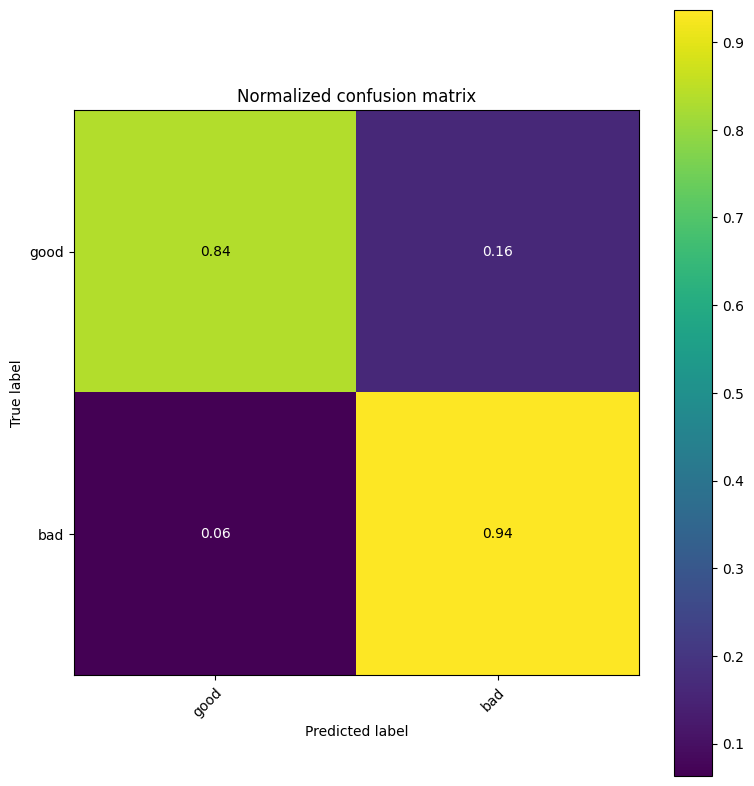

In [54]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = np.array(['good', 'bad'])
plot_conf_mat(y_test, y_pred, class_names)

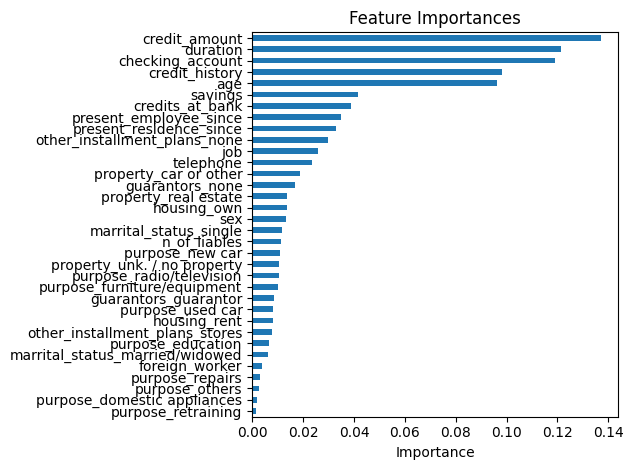

In [55]:
importances =  model.feature_importances_
features = x_train.columns

importances_df = pd.Series(importances, index=features).sort_values(ascending=True)

importances_df.plot(kind='barh', title='Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [56]:
explainer = shap.TreeExplainer(model)

x_test_xai = x_test.sample(200, random_state=42)

shap_values = explainer(x_test_xai)

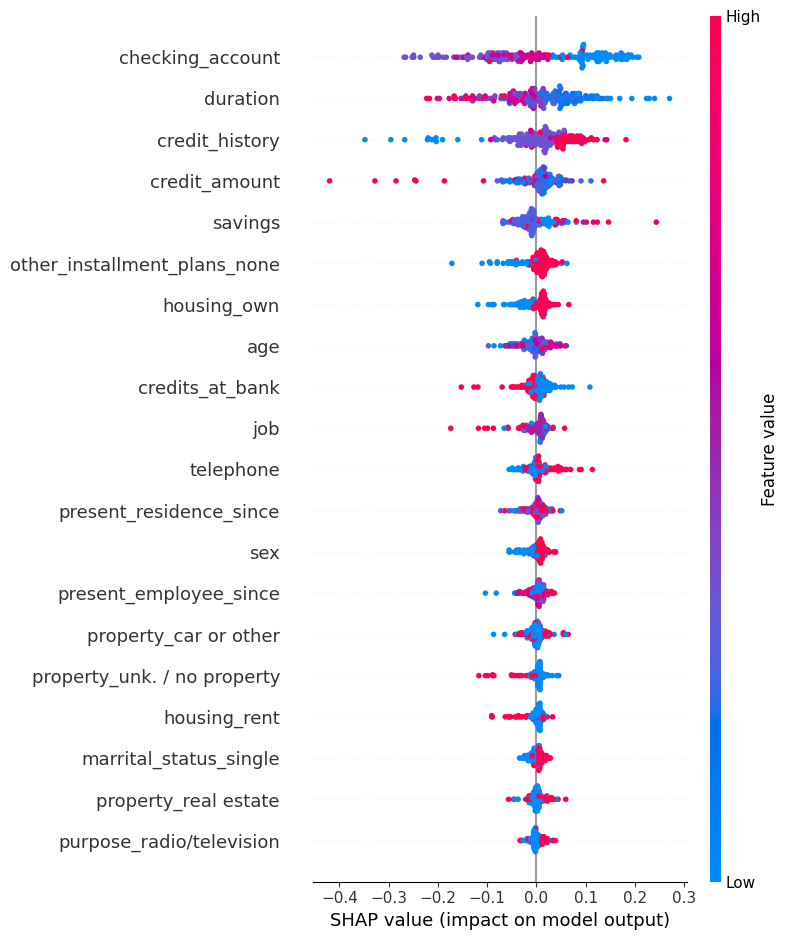

In [57]:
shap.summary_plot(shap_values[:, :, 1], x_test_xai)

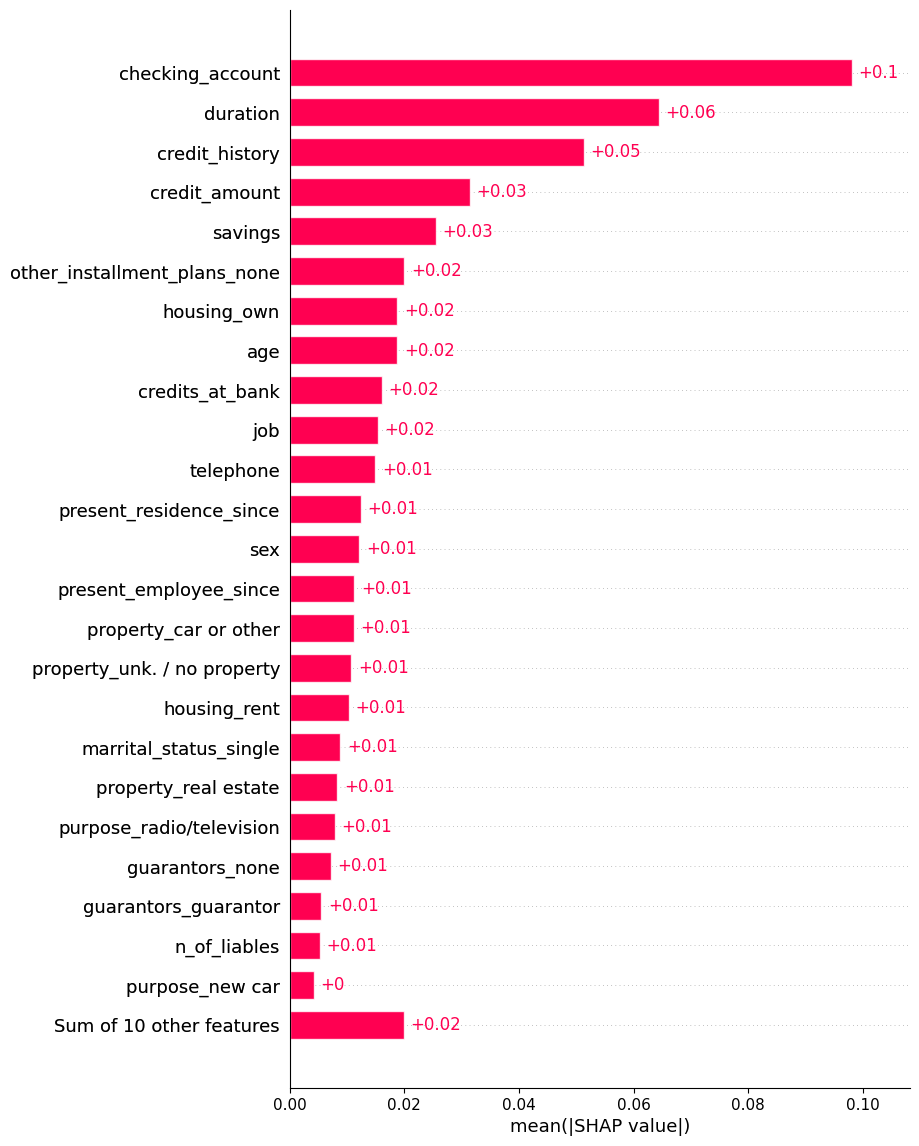

In [58]:
shap.plots.bar(shap_values[:,:,1], max_display=25)

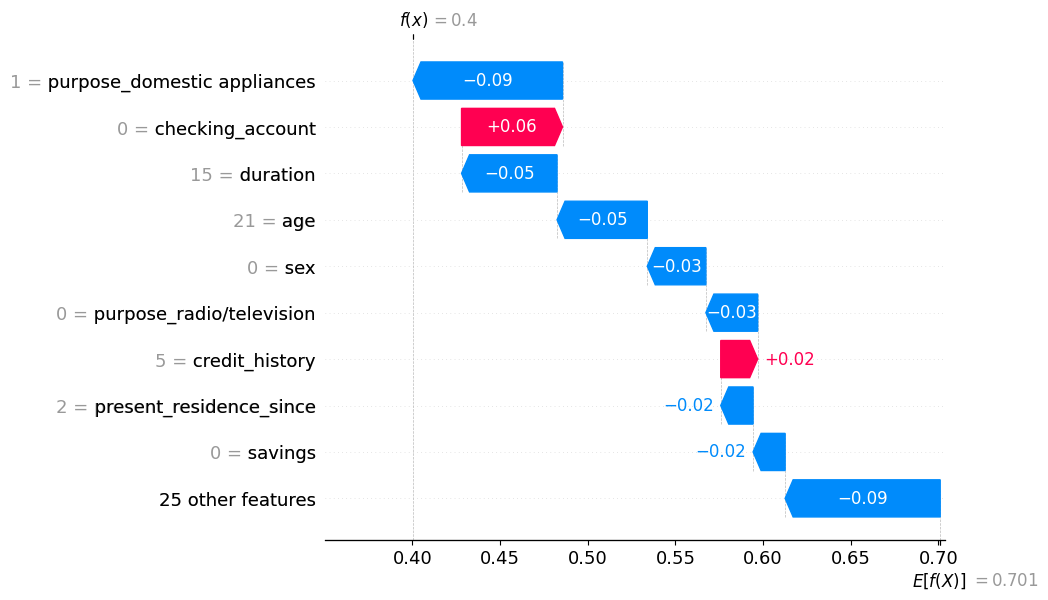

In [59]:
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx,:,1])

In [63]:
shap_data = {
    "shap_values": shap_values.values.tolist(),
    "data": x_test_xai,
    "feature_names": x_test_xai.columns.tolist(),
}

metrics = {
    "confusion_matrix": cm_normalized,
    "classification_report": class_report,
}

joblib.dump({
    "model": model, 
    "metrics": make_serializable(metrics),
    "shap": shap_data,
    }, SAVED_MODELS_DIR + SAVED_MODEL_FILE)

['../backend/saved_models/random_forest.pkl']